<a href="https://colab.research.google.com/github/redwineyards/autoencoders/blob/main/sparse/sparse_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
seed=42
torch.manual_seed(seed)
if device=='cuda': torch.cuda.manual_seed_all(seed)

root="/content/data"
trans=transforms.Compose([transforms.ToTensor()])
training_set=torchvision.datasets.MNIST(root=root,train=True,transform=trans,download=True)
test_set=torchvision.datasets.MNIST(root=root, train=False,transform=trans, download=True)

True


In [20]:
num_epochs=20
learning_rate=1e-3
batch_size=128
beta=0.01
rho=0.05
train_loader=torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [105]:
class SparseAE(nn.Module):
  def __init__(self):
    super(SparseAE,self).__init__()
    self.enc1=nn.Sequential(nn.Conv2d(1,8,5,stride=1),nn.ReLU())
    self.enc2=nn.Sequential(nn.Conv2d(8,16,3,stride=2),nn.ReLU())
    self.enc3=nn.Sequential(nn.Conv2d(16,32,1,stride=1),nn.ReLU())
    self.enc4=nn.MaxPool2d(2, 2)
    self.bottle=nn.MaxPool2d(2,2)

    self.dec0=nn.Sequential(nn.ConvTranspose2d(32,32,3, stride=2),nn.ReLU())
    self.dec1=nn.Sequential(nn.ConvTranspose2d(32,16,3, stride=2),nn.ReLU())
    self.dec2=nn.Sequential(nn.ConvTranspose2d(16,8,5, stride=2),nn.ReLU())
    self.dec3=nn.Sequential(nn.ConvTranspose2d(8,1,4, stride=1),nn.ReLU())
    self.reconstr=nn.Sigmoid()

  def encode(self,x):
    out=self.enc1(x)
    out=self.enc2(out)
    out=self.enc3(out)
    out=self.bottle(out)
    return out

  def decode(self,x):
    out=self.dec1(x)
    out=self.dec2(out)
    out=self.dec3(out)
    out=self.reconstr(out)
    return out
    
  def forward(self,x):
    activations=[]
    out=self.enc1(x)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    #if self.training==True: activations.append(out)
    out=self.enc2(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.enc3(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.enc4(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.bottle(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.dec0(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.dec1(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.dec2(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.dec3(out)
    if self.training==True: activations.append(torch.mean(out,dim=1))
    out=self.reconstr(out)
    return out, activations

In [106]:
def klloss(activations,rho):
  loss=0
  for mean in activations:
    loss+=F.kl_div(mean,rho*torch.ones_like(mean))
  return torch.abs(loss)

In [101]:
def train(model,train_loader,num_epochs,learning_rate,beta,rho):
  losses=[]
  lossfn=nn.BCELoss()
  optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  for epoch in range(num_epochs):
    for i,(images,_) in enumerate(train_loader):
      images=images.to(device)
      output,activations=model.forward(images)
      loss=lossfn(output,images.float()) + beta*klloss(activations,rho)
      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
  return losses

In [107]:
def evaluate(model,test_loader):
  lossfn=torch.nn.BCELoss()
  model.eval()
  with torch.no_grad():
    total=0
    for i,(images,_) in enumerate(test_loader):
      images=images.to(device)
      output,_=model.forward(images)
      total+=lossfn(output,images.float())
    
    loss=total/len(test_loader)
    print("model test loss on MNIST test set:", loss.item())

In [108]:
model=SparseAE().to(device)
losses=train(model,train_loader,num_epochs,learning_rate,beta,rho)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch [1/20], Loss: 0.6923
Epoch [2/20], Loss: 0.6866
Epoch [3/20], Loss: 0.6778
Epoch [4/20], Loss: 0.6742
Epoch [5/20], Loss: 0.6714
Epoch [6/20], Loss: 0.6752
Epoch [7/20], Loss: 0.6755
Epoch [8/20], Loss: 0.6755
Epoch [9/20], Loss: 0.6755
Epoch [10/20], Loss: 0.6763
Epoch [11/20], Loss: 0.6729
Epoch [12/20], Loss: 0.6729
Epoch [13/20], Loss: 0.6678
Epoch [14/20], Loss: 0.6699
Epoch [15/20], Loss: 0.6703
Epoch [16/20], Loss: 0.6689
Epoch [17/20], Loss: 0.6703
Epoch [18/20], Loss: 0.6707
Epoch [19/20], Loss: 0.6681
Epoch [20/20], Loss: 0.6675


In [109]:
evaluate(model,test_loader)

model test loss on MNIST test set: 0.653213381767273


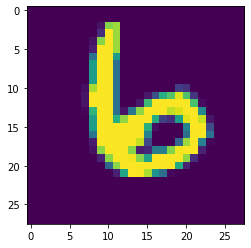

In [132]:
tens1=training_set[1504][0].reshape(-1,1,28,28)
#tens1=torch.rand(1,1,28,28)*0.1
test1=np.squeeze(tens1.numpy())
plt.imshow(test1)

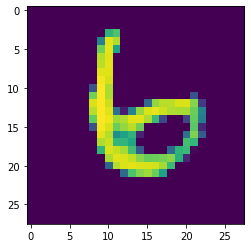

In [133]:
with torch.no_grad():
  tens1_reconstr,_=model.forward(tens1.to(device))
  test1_reconstr=np.squeeze(tens1_reconstr.cpu().numpy())
  plt.imshow(test1_reconstr)